In [1]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # Example model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report

import joblib


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Load dataset from Google Drive
drive_path = '/content/drive/MyDrive/IDS data sets/'
train_file_minmax = drive_path + 'NF-BoT-IoT-V2_5000 samples_minmax_normalized_train.csv'
test_file_minmax = drive_path + 'NF-BoT-IoT-V2_5000 samples_minmax_normalized_test.csv'

train_data = pd.read_csv(train_file_minmax)
test_data = pd.read_csv(test_file_minmax)


Mounted at /content/drive


In [3]:
X_train = train_data.drop(columns=['Attack','FTP_COMMAND_RET_CODE'])
y_train = train_data['Attack']

In [4]:
X_test = test_data.drop(columns=['Attack','FTP_COMMAND_RET_CODE'])
y_test = test_data['Attack']

In [5]:
# Display the number of NaN values per column in X_train and X_test
print("NaN values in each column of X_train:")
print(X_train.isna().sum())

print("\nNaN values in each column of X_test:")
print(X_test.isna().sum())

# Drop columns with any NaN values from X_train and X_test
X_train = X_train.dropna(axis=1)
X_test = X_test.dropna(axis=1)

NaN values in each column of X_train:
L4_SRC_PORT                       0
L4_DST_PORT                       0
PROTOCOL                          0
L7_PROTO                          0
IN_BYTES                          0
IN_PKTS                           0
OUT_BYTES                         0
OUT_PKTS                          0
TCP_FLAGS                         0
CLIENT_TCP_FLAGS                  0
SERVER_TCP_FLAGS                  0
FLOW_DURATION_MILLISECONDS        0
DURATION_IN                       0
DURATION_OUT                      0
MIN_TTL                           0
MAX_TTL                           0
LONGEST_FLOW_PKT                  0
SHORTEST_FLOW_PKT                 0
MIN_IP_PKT_LEN                    0
MAX_IP_PKT_LEN                    0
SRC_TO_DST_SECOND_BYTES           0
DST_TO_SRC_SECOND_BYTES           0
RETRANSMITTED_IN_BYTES            0
RETRANSMITTED_IN_PKTS             0
RETRANSMITTED_OUT_BYTES           0
RETRANSMITTED_OUT_PKTS            0
SRC_TO_DST_AVG_THROUGHPUT 

Attack
DDoS              1904
DoS               1771
Reconnaissance     303
Benign              21
Theft                1
Name: count, dtype: int64


<Axes: xlabel='Attack', ylabel='count'>

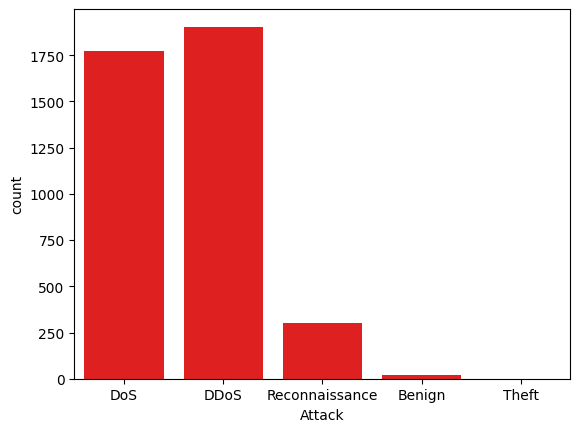

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
X = train_data.drop(['Attack'],axis= 1 )
y = train_data.loc[:, 'Attack']
print( train_data.loc[:, 'Attack'].value_counts())

sns.countplot(data=train_data,x='Attack',color='red')

In [7]:
def GrdSrch_Tune(model, X, y, params):

    clf = GridSearchCV(model, params, scoring ='recall_weighted', cv = 5, n_jobs=-1)
    clf.fit(X, y)

    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is{} :" .format(clf.best_params_))

    return (clf.best_score_)

In [8]:
param_SVC = {
    'C': [0.1, 1, 10],               # Smaller range for regularization to control overfitting
    'kernel': ['linear', 'rbf','sigmoid'],      # Focus on linear and rbf, typically more effective for SVMs
    'gamma': [0.001, 0.01, 0.1, 1]    # Lower range to prevent overfitting
}


In [9]:
svc = GrdSrch_Tune(SVC(random_state=42),X_train,y_train,param_SVC)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


best score is : 0.98675
best estimator is : SVC(C=10, gamma=0.1, random_state=42)
best Params is{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} :


In [10]:
support_vector_classifier = SVC(C=10, gamma=0.1, kernel='rbf',probability=True, random_state=42)
support_vector_classifier.fit(X_train, y_train)

SVC(C=10, gamma=0.1, probability=True, random_state=42)

In [11]:
y_pred_svc = support_vector_classifier.predict(X_test)
y_pred_svc

array(['DDoS', 'DoS', 'DDoS', ..., 'DoS', 'DDoS', 'DoS'], dtype=object)

In [12]:
#Compare actual y test V.S y_predict
df_rep_svc = pd.DataFrame({'actual data':y_test, 'predicted data':y_pred_svc})
df_rep_svc.head(10)

,actual data,predicted data
0,DDoS,DDoS
1,DoS,DoS
2,DDoS,DDoS
3,DoS,DoS
4,DDoS,DDoS
5,DoS,DoS
6,DDoS,DDoS
7,DoS,DoS
8,DDoS,DDoS
9,DoS,Reconnaissance


In [13]:
import joblib

# Save the trained Decision Tree model to a file
joblib.dump(support_vector_classifier, "/content/drive/MyDrive/IDS data sets/support_vector_classifierel.joblib")


['/content/drive/MyDrive/IDS data sets/support_vector_classifierel.joblib']

In [14]:
rep_svc = classification_report(y_test,y_pred_svc)
print(rep_svc)

                precision    recall  f1-score   support

        Benign       1.00      0.83      0.91         6
          DDoS       0.99      0.99      0.99       484
           DoS       0.98      0.97      0.98       436
Reconnaissance       0.92      0.96      0.94        75

      accuracy                           0.98      1001
     macro avg       0.97      0.94      0.95      1001
  weighted avg       0.98      0.98      0.98      1001



Text(0.5, 1.0, 'Confusion Matrix')

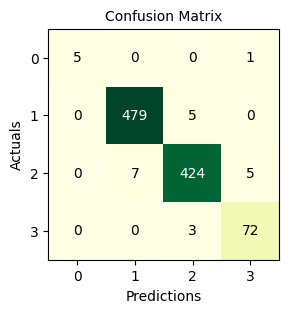

In [15]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

conf_svm = confusion_matrix(y_test,y_pred_svc)
fig, ax = plot_confusion_matrix(conf_mat=conf_svm,figsize=(3,3), cmap=plt.cm.YlGn)

plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

In [16]:
from sklearn.model_selection import cross_val_score
scores_svc = cross_val_score(support_vector_classifier, X_train, y_train ,cv = 10, scoring = 'recall_weighted')
avg_scores_svc = scores_svc.mean()
avg_scores_svc

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.98675

In [17]:
from sklearn.model_selection import cross_val_score
scores_svc_test = cross_val_score(support_vector_classifier, X_test, y_test ,cv = 10, scoring = 'recall_weighted')
avg_scores_svc_test = scores_svc.mean()
avg_scores_svc_test

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


0.98675

In [18]:
print("Train score is:",format(avg_scores_svc))
print("Test score is:",format(avg_scores_svc_test))

Train score is: 0.98675
Test score is: 0.98675


In [19]:
X_train.shape[1]

39

In [20]:
X_test.shape[1]

39